Import Libraries and Load Data


In [6]:
from google.colab import files
uploaded = files.upload()


Saving store_forecasting_data (1) (1).zip to store_forecasting_data (1) (1) (2).zip


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
import datetime


In [8]:
import zipfile

# Path to the uploaded ZIP file
zip_file_path = '/content/store_forecasting_data (1) (1).zip'

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')


import os
os.listdir('/content/')


['.config',
 'store_forecasting_data (1) (1).zip',
 'store_forecasting_data',
 '__MACOSX',
 'store_forecasting_data (1) (1) (2).zip',
 'store_forecasting_data (1) (1) (1).zip',
 'sample_data']

In [9]:
import pandas as pd

train_df = pd.read_csv('/content/store_forecasting_data/train.csv')
test_df = pd.read_csv('/content/store_forecasting_data/test.csv')
stores_df = pd.read_csv('/content/store_forecasting_data/stores.csv')
oil_df = pd.read_csv('/content/store_forecasting_data/oil.csv')
sample_submission_df = pd.read_csv('/content/store_forecasting_data/sample_submission.csv')
transactions_df = pd.read_csv('/content/store_forecasting_data/transactions.csv')
holidays_events_df = pd.read_csv('/content/store_forecasting_data/holidays_events.csv')


In [10]:
print("Train Dataset:")
print(train_df.head())

print("\nTest Dataset:")
print(test_df.head())

print("\nStores Dataset:")
print(stores_df.head())

print("\nOil Dataset:")
print(oil_df.head())

print("\nHolidays Events Dataset:")
print(holidays_events_df.head())

print("\ntransactions Dataset:")
print(transactions_df.head())


Train Dataset:
   id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

Test Dataset:
        id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

Stores Dataset:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          

Data Preprocessing (Datetime Conversion & Missing Value Handling)



In [11]:
# Convert 'date' column to datetime format
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
oil_df['date'] = pd.to_datetime(oil_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])
transactions_df['date'] = pd.to_datetime(transactions_df['date'])

# Handle missing values in oil prices by filling gaps with interpolation
oil_df['dcoilwtico'] = oil_df['dcoilwtico'].interpolate(method='linear')

# Check
train_df.isnull().sum(), test_df.isnull().sum(), oil_df.isnull().sum(), holidays_events_df.isnull().sum(), transactions_df.isnull().sum()


(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date          0
 dcoilwtico    1
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64)

Merge Data

In [12]:
print(train_df.columns)


Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion'], dtype='object')


In [13]:
# Rename the 'dcoilwtico' column in the oil_df
oil_df = oil_df.rename(columns={'dcoilwtico': 'dcoilwtico_oil'})

# merge the oil prices data into the train_df
train_df = train_df.merge(oil_df[['date', 'dcoilwtico_oil']], on='date', how='left')


In [14]:
# Assuming the column has been renamed in the oil_df to avoid conflict
oil_df = oil_df.rename(columns={'dcoilwtico': 'dcoilwtico_oil'})

# Merge oil prices data into train_df using the new column name 'dcoilwtico_oil'
train_df = train_df.merge(oil_df[['date', 'dcoilwtico_oil']], on='date', how='left')


train_df = train_df.merge(holidays_events_df[['date', 'transferred']], on='date', how='left')
train_df = train_df.merge(transactions_df[['date', 'store_nbr', 'transactions']], on=['date', 'store_nbr'], how='left')
train_df = train_df.merge(stores_df[['store_nbr', 'city', 'state', 'type', 'cluster']], on='store_nbr', how='left')


train_df.head()


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico_oil_x,dcoilwtico_oil_y,transferred,transactions,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13


In [15]:
print(holidays_events_df.columns)


Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


In [16]:
# Strip spaces in column names to ensure correct matching
holidays_events_df.columns = holidays_events_df.columns.str.strip()


print(holidays_events_df.columns)


Index(['date', 'type', 'locale', 'locale_name', 'description', 'transferred'], dtype='object')


In [17]:
print(holidays_events_df.head())


        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False  


In [18]:
# Rename existing 'transferred' column in train_df if present to avoid conflict
train_df = train_df.rename(columns={'transferred': 'transferred_train'}, errors='ignore')

# Merge 'train_df' with 'holidays_events_df' based on the 'date' column
train_df = train_df.merge(holidays_events_df[['date', 'transferred']], on='date', how='left', suffixes=('_train', '_holiday'))

# Ensure that 'transferred' column is of boolean type before converting to integer
train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)

# Create a new binary column 'is_holiday' based on 'transferred'
train_df['is_holiday'] = train_df['transferred'].astype(int)

# Check the merged result
train_df.head()


<ipython-input-18-661867d25b13>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico_oil_x,dcoilwtico_oil_y,transferred_train,transactions,city,state,type,cluster,transferred,is_holiday
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0


In [19]:
# Rename existing 'transferred' column in train_df if present to avoid conflict
train_df = train_df.rename(columns={'transferred': 'transferred_train'}, errors='ignore')

# Merge 'train_df' with 'holidays_events_df' based on the 'date' column
train_df = train_df.merge(holidays_events_df[['date', 'transferred']], on='date', how='left', suffixes=('_train', '_holiday'))

# Ensure that 'transferred' column is of boolean type before converting to integer
train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)

# Create a new binary column 'is_holiday' based on 'transferred'
train_df['is_holiday'] = train_df['transferred'].astype(int)

# Check the merged result
train_df.head()


<ipython-input-19-661867d25b13>:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico_oil_x,dcoilwtico_oil_y,transferred_train,transactions,city,state,type,cluster,transferred_train,is_holiday,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False


In [20]:

train_df['date'] = pd.to_datetime(train_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date'])

# Reset the index of both dataframes before merging to avoid index mismatches
train_df.reset_index(drop=True, inplace=True)
holidays_events_df.reset_index(drop=True, inplace=True)

# Rename existing 'transferred' column in train_df if present to avoid conflict
train_df = train_df.rename(columns={'transferred': 'transferred_train'}, errors='ignore')

# Merge 'train_df' with 'holidays_events_df' based on the 'date' column
train_df = train_df.merge(holidays_events_df[['date', 'transferred']], on='date', how='left', suffixes=('_train', '_holiday'))

# Ensure that 'transferred' column is of boolean type before converting to integer
train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)

# Create a new binary column 'is_holiday' based on 'transferred'
train_df['is_holiday'] = train_df['transferred'].astype(int)


train_df.head()


<ipython-input-20-f7cc852f2792>:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico_oil_x,dcoilwtico_oil_y,transferred_train,transactions,city,state,type,cluster,transferred_train,is_holiday,transferred_train,transferred
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False,False
1,1,2013-01-01,1,BABY CARE,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False,False
2,2,2013-01-01,1,BEAUTY,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False,False
3,3,2013-01-01,1,BEVERAGES,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False,False
4,4,2013-01-01,1,BOOKS,0.0,0,NaN,NaN,False,NaN,Quito,Pichincha,D,13,False,0,False,False


In [21]:
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(1))
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.shift(7))
train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).mean().shift(1))
train_df['sales_rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(window=7).std().shift(1))



In [22]:
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
train_df['sales_rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).std())

train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales_rolling_mean_7'].shift(1)
train_df['sales_rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales_rolling_std_7'].shift(1)


In [23]:
import pandas as pd

# Assuming your CSV file is named 'your_data.csv'
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Load the holidays_events_df DataFrame
holidays_events_df = pd.read_csv('/content/store_forecasting_data/holidays_events.csv')

# Now you can proceed with your calculations
# Convert 'date' column to datetime format in both DataFrames
train_df['date'] = pd.to_datetime(train_df['date'])
holidays_events_df['date'] = pd.to_datetime(holidays_events_df['date']) # Convert to datetime before merging

# Extracting day, month, year, and weekday from the 'date' column
train_df['day'] = train_df['date'].dt.day
train_df['month'] = train_df['date'].dt.month
train_df['year'] = train_df['date'].dt.year
train_df['weekday'] = train_df['date'].dt.weekday

# Create a binary feature for whether it's a weekend or not (weekend = 5 or 6)
train_df['is_weekend'] = train_df['weekday'].isin([5, 6]).astype(int)

# Merge with holidays_events_df to get the 'transferred' column
train_df = pd.merge(train_df, holidays_events_df[['date', 'transferred']], on='date', how='left')

# Ensure the 'transferred' column is of the correct data type
train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)

# Rename the 'transferred' column to 'transferred_holiday'
train_df = train_df.rename(columns={'transferred': 'transferred_holiday'})


# Add holiday-related features (holiday = 1, not holiday = 0)
train_df['is_holiday'] = train_df['transferred_holiday'].astype(int)

# Add lag features for sales (previous day's sales, etc.)
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

# Fill NaN values in lag features (optional, can fill with mean or 0)
train_df['sales_lag_1'] = train_df['sales_lag_1'].fillna(0)
train_df['sales_lag_7'] = train_df['sales_lag_7'].fillna(0)

# Add rolling statistics for sales (mean and std over the past 7 days)
train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).mean())
train_df['sales_rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].transform(lambda x: x.rolling(7, min_periods=1).std())

# Shift rolling statistics by 1 day
train_df['sales_rolling_mean_7'] = train_df.groupby(['store_nbr', 'family'])['sales_rolling_mean_7'].shift(1)
train_df['sales_rolling_std_7'] = train_df.groupby(['store_nbr', 'family'])['sales_rolling_std_7'].shift(1)

# Fill NaN values in rolling statistics (optional, can fill with mean or 0)
train_df['sales_rolling_mean_7'] = train_df['sales_rolling_mean_7'].fillna(0)
train_df['sales_rolling_std_7'] = train_df['sales_rolling_std_7'].fillna(0)

# Reset index to avoid misalignment issues when assigning new columns
train_df = train_df.reset_index(drop=True)


train_df.head()

<ipython-input-23-49cc9819c6a9>:27: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['transferred'] = train_df['transferred'].fillna(False).astype(bool)


,id,date,store_nbr,family,sales,onpromotion,day,month,year,weekday,is_weekend,transferred_holiday,is_holiday,sales_lag_1,sales_lag_7,sales_rolling_mean_7,sales_rolling_std_7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,2013,1,0,False,0,0.0,0.0,0.0,0.0
1,1,2013-01-01,1,BABY CARE,0.0,0,1,1,2013,1,0,False,0,0.0,0.0,0.0,0.0
2,2,2013-01-01,1,BEAUTY,0.0,0,1,1,2013,1,0,False,0,0.0,0.0,0.0,0.0
3,3,2013-01-01,1,BEVERAGES,0.0,0,1,1,2013,1,0,False,0,0.0,0.0,0.0,0.0
4,4,2013-01-01,1,BOOKS,0.0,0,1,1,2013,1,0,False,0,0.0,0.0,0.0,0.0


Fill Missing Values



In [24]:
# Fill missing values for lag and rolling features
train_df.fillna(method='bfill', inplace=True)


<ipython-input-24-8282989575dd>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df.fillna(method='bfill', inplace=True)


Exploratory Data Analysis (EDA)

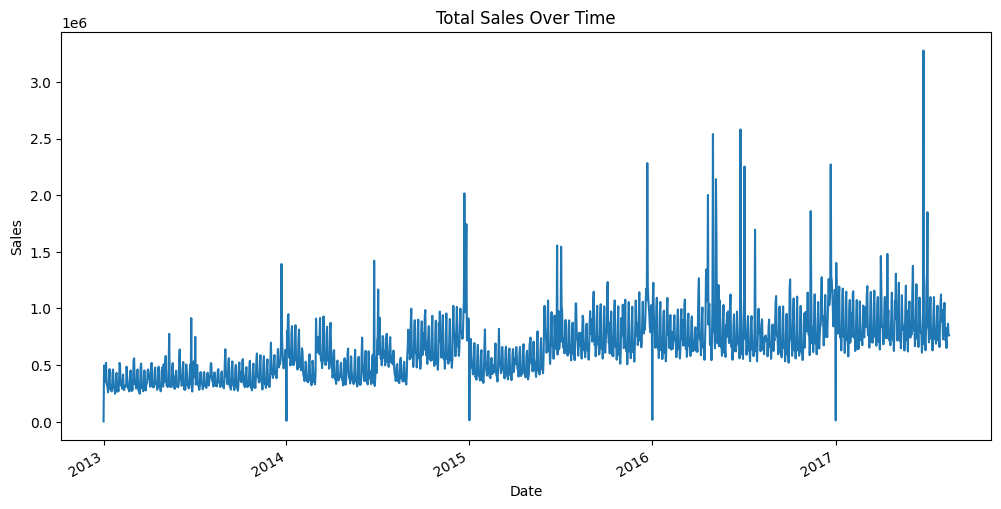

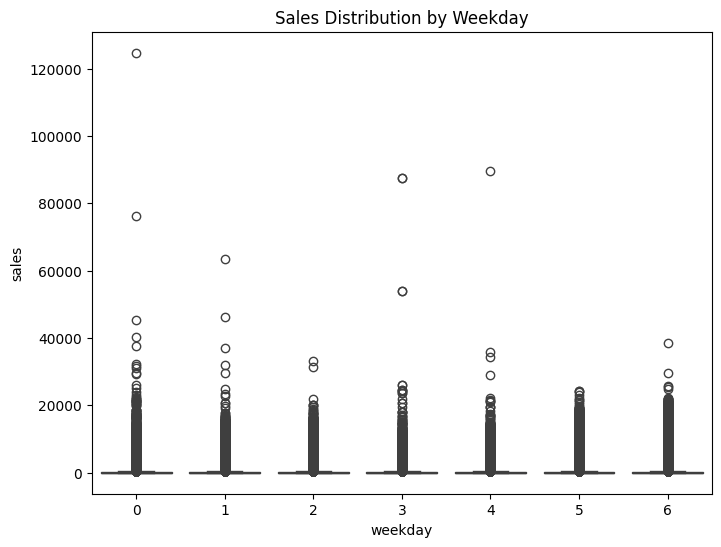

<Figure size 1200x600 with 0 Axes>

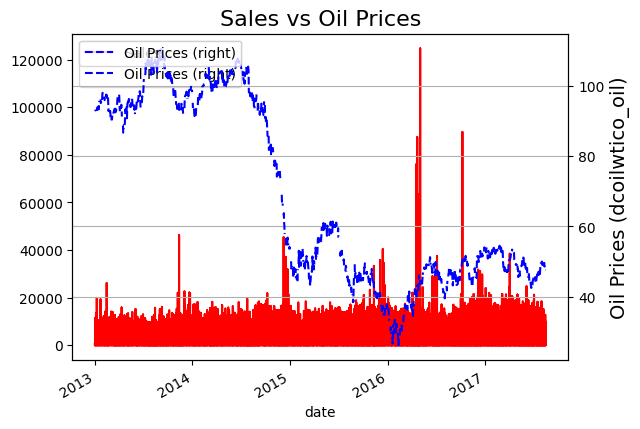

In [25]:
# Import necessary libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns  # Import seaborn for boxplot

# Load the oil data
oil_df = pd.read_csv('/content/store_forecasting_data/oil.csv')

# Rename the 'dcoilwtico' column in oil_df to 'dcoilwtico_oil'
oil_df = oil_df.rename(columns={'dcoilwtico': 'dcoilwtico_oil'})

# Convert 'date' column to datetime in oil_df
oil_df['date'] = pd.to_datetime(oil_df['date']) # This line ensures that 'date' is datetime

# Merge the oil prices data into train_df
train_df = train_df.merge(oil_df[['date', 'dcoilwtico_oil']], on='date', how='left')

# Plotting sales trends over time
plt.figure(figsize=(12, 6))
train_df.groupby('date')['sales'].sum().plot()
plt.title('Total Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plotting sales by day of the week
plt.figure(figsize=(8, 6))
sns.boxplot(x='weekday', y='sales', data=train_df)  # Use sns.boxplot
plt.title('Sales Distribution by Weekday')
plt.show()

# Plotting sales vs oil prices with customizations
plt.figure(figsize=(12, 6))

# Plot sales data
ax = train_df.plot(x='date', y='sales', color='red', label='Sales', legend=True)

# Plot oil prices on secondary y-axis
train_df.plot(x='date', y='dcoilwtico_oil', ax=ax, color='blue', label='Oil Prices', secondary_y=True, linestyle='--', legend=True)

# Set the title and labels
plt.title('Sales vs Oil Prices', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Sales', fontsize=14)

# Set secondary y-axis label for oil prices
ax.right_ax.set_ylabel('Oil Prices (dcoilwtico_oil)', fontsize=14)

plt.grid(True)
plt.legend(loc='upper left')

plt.show()

In [26]:
# Rename the column in the oil_df before merging if it hasn't been renamed already
# oil_df = oil_df.rename(columns={'dcoilwtico': 'dcoilwtico_oil'}) # This line might be redundant if you've already renamed it

# Now merge the oil prices data into train_df, but drop existing 'dcoilwtico_oil' from train_df
train_df = train_df.drop(columns=['dcoilwtico_oil'], errors='ignore') # Drop the column if it exists
train_df = train_df.merge(oil_df[['date', 'dcoilwtico_oil']], on='date', how='left')

# Verify if the column is now available
print(train_df.columns)

Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'day',
       'month', 'year', 'weekday', 'is_weekend', 'transferred_holiday',
       'is_holiday', 'sales_lag_1', 'sales_lag_7', 'sales_rolling_mean_7',
       'sales_rolling_std_7', 'dcoilwtico_oil'],
      dtype='object')


 Modeling

Train-Test Split

In [27]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_set, test_set = train_test_split(train_df, test_size=0.2, shuffle=False)
X_train = train_set.drop(['sales', 'date'], axis=1)
y_train = train_set['sales']
X_test = test_set.drop(['sales', 'date'], axis=1)
y_test = test_set['sales']


Baseline Model (Naive)

In [28]:
import pandas as pd  # Make sure pandas is imported

# Assuming your test data is in 'store_forecasting_data/test.csv'
test_df = pd.read_csv('/content/store_forecasting_data/test.csv')

print(test_df.columns)


Index(['id', 'date', 'store_nbr', 'family', 'onpromotion'], dtype='object')


In [29]:
from sklearn.metrics import mean_absolute_error


In [30]:
import pandas as pd

# Assuming your CSV file is named 'your_data.csv'
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Now you can proceed with your calculations
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)

# ... (rest of your code)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the train_df DataFrame before using it
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Define the features and target variable
X = train_df[['store_nbr', 'family', 'onpromotion']]  # Features for baseline model
y = train_df['sales']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create 'sales_lag_1' feature in train dataset
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)

# Merge 'sales_lag_1' feature from train dataset to test dataset
# Use 'id' for merging if it's available in both train_df and X_test

if 'id' in train_df.columns and 'id' in X_test.columns:
    X_test = X_test.merge(train_df[['id', 'sales_lag_1']], on='id', how='left')
else:
    # If 'id' is not available, use other common columns for merging
    # For example, if 'store_nbr' and 'family' are common:
    X_test = X_test.merge(train_df[['store_nbr', 'family', 'sales_lag_1']], on=['store_nbr', 'family'], how='left')

# Naive forecasting model (previous day's sales as prediction)
y_pred_baseline = X_test['sales_lag_1']

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the train_df DataFrame before using it
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Define the features and target variable
X = train_df[['store_nbr', 'family', 'onpromotion']]  # Features for baseline model
y = train_df['sales']  # Target variable

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create 'sales_lag_1' feature in train dataset
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)

# Merge 'sales_lag_1' feature from train dataset to test dataset
# Use 'id' for merging if it's available in both train_df and X_test
# If 'id' is not available, use other common columns for merging
# For example, if 'store_nbr' and 'family' are common:
X_test = X_test.merge(train_df[['store_nbr', 'family', 'sales_lag_1']], on=['store_nbr', 'family'], how='left')


# Naive forecasting model (previous day's sales as prediction)
y_pred_baseline = X_test['sales_lag_1']


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

# Load the train_df DataFrame before using it
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Now you can proceed with your calculations
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

# Define the features and target variable
X = train_df[['sales_lag_1', 'sales_lag_7', 'onpromotion']]  # You can add more features as needed
y = train_df['sales']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now create 'sales_lag_1' feature in X_test (using the previous day's sales from train_df)
# Assuming 'id' is a column in your DataFrame, otherwise adjust accordingly
X_test['sales_lag_1'] = X_test.index.map(train_df.set_index(train_df.index)['sales'].shift(1))


# Naive forecasting model (previous day's sales as prediction)
y_pred_baseline = X_test['sales_lag_1']

# Model evaluation
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
print(f'Baseline MAE: {mae_baseline}')


Baseline MAE: 606.2934536856205


ARIMA Model

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the train_df DataFrame before using it
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Now you can proceed with your calculations
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

# Define the features and target variable
X = train_df[['sales_lag_1', 'sales_lag_7', 'onpromotion']]  # You can add more features as needed
y = train_df['sales']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Assuming 'id' is a column in your DataFrame, otherwise adjust accordingly
X_test['sales_lag_1'] = X_test.index.map(train_df.set_index(train_df.index)['sales'].shift(1))

# Now create 'sales_lag_1' feature in X_test (using the previous day's sales from train_df)
# Assuming 'id' is a column in your DataFrame, otherwise adjust accordingly
X_test['sales_lag_1'] = X_test.index.map(train_df.set_index(train_df.index)['sales'].shift(1))

# Before fitting the ARIMA model, create the train_set DataFrame
train_set = pd.concat([X_train, y_train], axis=1)

# Fit an ARIMA model
arima_model = ARIMA(train_set['sales'], order=(5, 1, 0)) # Example parameters
arima_model_fit = arima_model.fit()

# Make predictions on test set
y_pred_arima = arima_model_fit.forecast(steps=len(y_test))[0]
mae_arima = mean_absolute_error(y_test, y_pred_arima)
print(f'ARIMA MAE: {mae_arima}')


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


Random Forest Regressor

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # Import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Load the train_df DataFrame before using it
train_df = pd.read_csv('/content/store_forecasting_data/train.csv')  # Replace 'your_data.csv' with the actual file path

# Now you can proceed with your calculations
train_df['sales_lag_1'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(1)
train_df['sales_lag_7'] = train_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

# Define the features and target variable
X = train_df[['sales_lag_1', 'sales_lag_7', 'onpromotion']]  # You can add more features as needed
y = train_df['sales']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now create 'sales_lag_1' feature in X_test (using the previous day's sales from train_df)
# Assuming 'id' is a column in your DataFrame, otherwise adjust accordingly
X_test['sales_lag_1'] = X_test.index.map(train_df.set_index(train_df.index)['sales'].shift(1))

# Train a Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f'Random Forest MAE: {mae_rf}')


XGBoost Model

In [ ]:
# Train an XGBoost model
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on test set
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f'XGBoost MAE: {mae_xgb}')


Model Evaluation

In [ ]:
# Plot actual vs predicted sales
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual Sales')
plt.plot(y_test.index, y_pred_rf, label='Random Forest Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales (Random Forest)')
plt.show()

# Print error metrics for the models
print(f'ARIMA MAE: {mae_arima}')
print(f'Random Forest MAE: {mae_rf}')
print(f'XGBoost MAE: {mae_xgb}')
